In [1]:
import pandas as pd
import numpy as np
import requests
import os

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
# Define the URL of the CSV file
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv"

In [3]:
# Check if the file already exists
if os.path.exists("laptops.csv"):
  print("laptops.csv already exists. Download canceled.")
else:
  # Download the file using requests (more secure and integrated)  
  response = requests.get(url)

  # Check for successful download
  if response.status_code == 200:
    # Write the data to a local CSV file
    with open("laptops.csv", "wb") as f:
      f.write(response.content)
    print("laptops.csv downloaded successfully!")
  else:
    print(f"Error downloading file: {response.status_code}")

laptops.csv already exists. Download canceled.


In [4]:
df = pd.read_csv('laptops.csv')

In [5]:
df.columns

Index(['Laptop', 'Status', 'Brand', 'Model', 'CPU', 'RAM', 'Storage',
       'Storage type', 'GPU', 'Screen', 'Touch', 'Final Price'],
      dtype='object')

In [6]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [7]:
df.columns

Index(['laptop', 'status', 'brand', 'model', 'cpu', 'ram', 'storage',
       'storage_type', 'gpu', 'screen', 'touch', 'final_price'],
      dtype='object')

In [8]:
# Use only the specified columns
df = df[['ram', 'storage', 'screen', 'final_price']]

# EDA

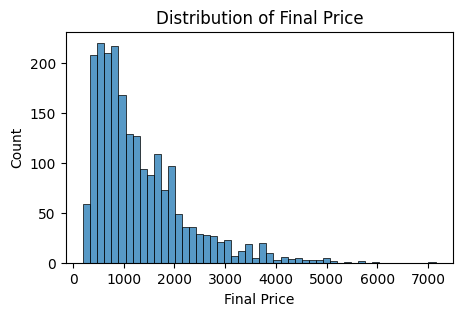

Skewness: 1.6495877663192549


In [9]:
# Create a histogram
plt.figure(figsize=(5, 3))
sns.histplot(df['final_price'], bins=50)
plt.title('Distribution of Final Price')
plt.xlabel('Final Price')
plt.ylabel('Count')
plt.show()

# Calculate skewness
skewness = df['final_price'].skew()
print(f'Skewness: {skewness}')

The provided histogram shows the distribution of the `final_price` variable. As you can see, the distribution has a clear **long tail** extending to the right. This indicates that there are a few very high-priced laptops (the tail), while most laptops are priced within a certain range (the main body of the distribution).

The skewness value of 1.6496 further confirms this observation. A positive skewness indicates a long tail to the right, which is consistent with the histogram.

This long-tailed distribution might suggest that there are some premium or luxury laptops that are significantly more expensive than the majority of laptops in the dataset.


In [27]:
df['final_price_log'] = np.log1p(df['final_price'])  # log(1 + x) to handle 0 values

In [28]:
skewness_log = df['final_price_log'].skew()
print(f'Skewness after log transformation: {skewness_log}')

Skewness after log transformation: 0.11418208788673762


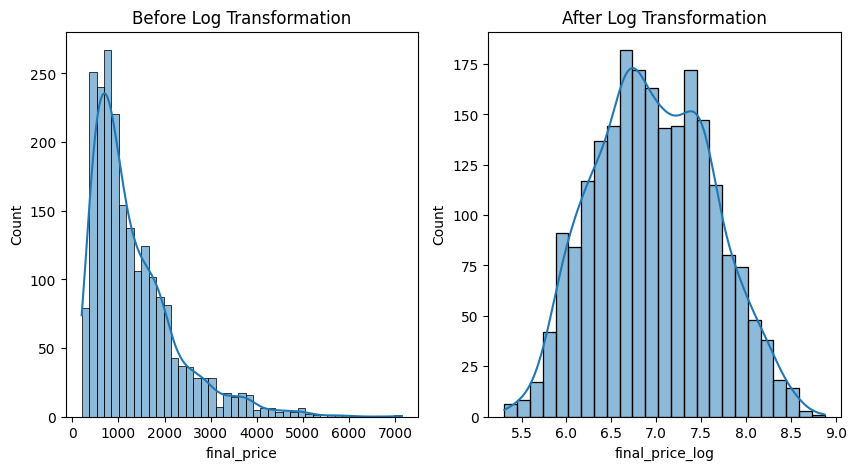

In [29]:
# Before log transformation
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
sns.histplot(df['final_price'], kde=True)
plt.title('Before Log Transformation')

# After log transformation
plt.subplot(1, 2, 2)
sns.histplot(df['final_price_log'], kde=True)
plt.title('After Log Transformation')

plt.show()


#Q1 There's one column with missing values. What is it?

In [10]:
df.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

In [11]:
# Count the number of empty values in each column
missing_values = df.isnull().sum()

# Display columns with more than 0
columns_with_missing_values = missing_values[missing_values > 0]

# Print the results with a better format
print(f"Columns with missing values are: {columns_with_missing_values.index.tolist()}")

Columns with missing values are: ['screen']


#Q2 What's the median (50% percentile) for variable 'ram'?

In [12]:
df.describe()

,ram,storage,screen,final_price
count,2160.000000,2160.000000,2156.000000,2160.000000
mean,15.413889,596.294444,15.168112,1312.638509
std,9.867815,361.220506,1.203329,911.475417
min,4.000000,0.000000,10.100000,201.050000
25%,8.000000,256.000000,14.000000,661.082500
50%,16.000000,512.000000,15.600000,1031.945000
75%,16.000000,1000.000000,15.600000,1708.970000
max,128.000000,4000.000000,18.000000,7150.470000


In [13]:
print(f"The median (50% percentile) for variable 'ram' is {df['ram'].median()}")

The median (50% percentile) for variable 'ram' is 16.0


#Prepare and split the dataset

In [14]:
df.shape

(2160, 4)

In [16]:
# Shuffle the dataset with seed 42 for reproducibility
df_shuffled = df.sample(frac=1, random_state=42)

# Split the dataset into train, validation, and test sets with proportions 60%, 20%, 20%
train_df, val_test_df = train_test_split(df_shuffled, test_size=0.4, random_state=42)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=42)

# Print the shapes of each dataset for verification
print("Train dataset shape:", train_df.shape)
print("Validation dataset shape:", val_df.shape)
print("Test dataset shape:", test_df.shape)

Train dataset shape: (1296, 4)
Validation dataset shape: (432, 4)
Test dataset shape: (432, 4)


In [32]:
# Shuffle the dataset with seed 42 for reproducibility
df_shuffled = df.sample(frac=1, random_state=42)

# Split the dataset into train, validation, and test sets with proportions 60%, 20%, 20%
train_df, val_test_df = train_test_split(df_shuffled, test_size=0.4)
val_df, test_df = train_test_split(val_test_df, test_size=0.5)

# Print the shapes of each dataset for verification
print("Train dataset shape:", train_df.shape)
print("Validation dataset shape:", val_df.shape)
print("Test dataset shape:", test_df.shape)

Train dataset shape: (1296, 5)
Validation dataset shape: (432, 5)
Test dataset shape: (432, 5)


#Q3

In [20]:
# Option 1: Fill missing values with 0
train_df_0 = train_df.fillna(0)
val_df_0 = val_df.fillna(0)

# Train linear regression model without regularization
model_0 = LinearRegression()
model_0.fit(train_df_0[['ram', 'storage', 'screen']], train_df_0['final_price'])

# Make predictions on validation set
y_pred_0 = model_0.predict(val_df_0[['ram', 'storage', 'screen']])

# Calculate RMSE
#rmse_0 = mean_squared_error(val_df_0['final_price'], y_pred_0, squared=False)
rmse_0 = root_mean_squared_error(val_df_0['final_price'], y_pred_0)

# Option 2: Fill missing values with mean
mean_ram = train_df['ram'].mean()
mean_storage = train_df['storage'].mean()
mean_screen = train_df['screen'].mean()

train_df_mean = train_df.fillna({'ram': mean_ram, 'storage': mean_storage, 'screen': mean_screen})
val_df_mean = val_df.fillna({'ram': mean_ram, 'storage': mean_storage, 'screen': mean_screen})

# Train linear regression model without regularization
model_mean = LinearRegression()
model_mean.fit(train_df_mean[['ram', 'storage', 'screen']], train_df_mean['final_price'])

# Make predictions on validation set
y_pred_mean = model_mean.predict(val_df_mean[['ram', 'storage', 'screen']])

# Calculate RMSE
#rmse_mean = mean_squared_error(val_df_mean['final_price'], y_pred_mean, squared=False)
rmse_mean = root_mean_squared_error(val_df_mean['final_price'], y_pred_mean)

# Compare RMSE
print("RMSE with 0:", round(rmse_0, 2))
print("RMSE with mean:", round(rmse_mean, 2))

RMSE with 0: 541.52
RMSE with mean: 541.75


In [33]:
# Option 1: Fill missing values with 0
train_df_0 = train_df.fillna(0)
val_df_0 = val_df.fillna(0)

# Train linear regression model without regularization
model_0 = LinearRegression()
model_0.fit(train_df_0[['ram', 'storage', 'screen']], train_df_0['final_price_log'])

# Make predictions on validation set
y_pred_0 = model_0.predict(val_df_0[['ram', 'storage', 'screen']])

# Calculate RMSE
#rmse_0 = mean_squared_error(val_df_0['final_price'], y_pred_0, squared=False)
rmse_0 = root_mean_squared_error(val_df_0['final_price_log'], y_pred_0)

# Option 2: Fill missing values with mean
mean_ram = train_df['ram'].mean()
mean_storage = train_df['storage'].mean()
mean_screen = train_df['screen'].mean()

train_df_mean = train_df.fillna({'ram': mean_ram, 'storage': mean_storage, 'screen': mean_screen})
val_df_mean = val_df.fillna({'ram': mean_ram, 'storage': mean_storage, 'screen': mean_screen})

# Train linear regression model without regularization
model_mean = LinearRegression()
model_mean.fit(train_df_mean[['ram', 'storage', 'screen']], train_df_mean['final_price_log'])

# Make predictions on validation set
y_pred_mean = model_mean.predict(val_df_mean[['ram', 'storage', 'screen']])

# Calculate RMSE
#rmse_mean = mean_squared_error(val_df_mean['final_price'], y_pred_mean, squared=False)
rmse_mean = root_mean_squared_error(val_df_mean['final_price_log'], y_pred_mean)

# Compare RMSE
print("RMSE with 0:", round(rmse_0, 2))
print("RMSE with mean:", round(rmse_mean, 2))

RMSE with 0: 0.45
RMSE with mean: 0.46


In [21]:
if round(rmse_0, 2) < round(rmse_mean, 2):
    print(f"Missing values filled with 0 because it has a smaller RMSE of {round(rmse_0, 2)}.")
else:
    print(f"Missing values filled with the mean because it has a smaller RMSE of {round(rmse_mean, 2)}.")

Missing values filled with 0 because it has a smaller RMSE of 541.52.


#Q4

In [21]:
# Fill missing values with 0
train_df = train_df.fillna(0)
val_df = val_df.fillna(0)

# Define the list of regularization parameters (r) to try
r_values = [0, 0.01, 0.1, 1, 5, 10, 100]

# Train and evaluate models for each r value
best_r = None
best_rmse = float('inf')
for r in r_values:
    print(r)
    model = Ridge(alpha=r)  # Use Ridge regression for regularization
    model.fit(train_df[['ram', 'storage', 'screen']], train_df['final_price'])
    y_pred = model.predict(val_df[['ram', 'storage', 'screen']])
    #rmse = mean_squared_error(val_df['final_price'], y_pred, squared=False)
    rmse = root_mean_squared_error(val_df['final_price'], y_pred)
    print(rmse)

    # Update best r and RMSE if current RMSE is better
    if rmse < best_rmse:
        best_r = r
        best_rmse = rmse

# Print the best r and its corresponding RMSE
print('\n')
print(f"Best regularization parameter (r): {best_r}")
print(f"Best RMSE: {round(best_rmse, 2)}")

0
675.0844456600814
0.01
675.0844370775981
0.1
675.0843598414332
1
675.0835880917201
5
675.0801715097375
10
675.0759313846438
100
675.005062673404


Best regularization parameter (r): 100
Best RMSE: 675.01


In [34]:
# Fill missing values with 0
train_df = train_df.fillna(0)
val_df = val_df.fillna(0)

# Define the list of regularization parameters (r) to try
r_values = [0, 0.01, 0.1, 1, 5, 10, 100]

# Train and evaluate models for each r value
best_r = None
best_rmse = float('inf')
for r in r_values:
    print(r)
    model = Ridge(alpha=r)  # Use Ridge regression for regularization
    model.fit(train_df[['ram', 'storage', 'screen']], train_df['final_price_log'])
    y_pred = model.predict(val_df[['ram', 'storage', 'screen']])
    #rmse = mean_squared_error(val_df['final_price'], y_pred, squared=False)
    rmse = root_mean_squared_error(val_df['final_price'], y_pred)
    print(rmse)

    # Update best r and RMSE if current RMSE is better
    if rmse < best_rmse:
        best_r = r
        best_rmse = rmse

# Print the best r and its corresponding RMSE
print('\n')
print(f"Best regularization parameter (r): {best_r}")
print(f"Best RMSE: {round(best_rmse, 2)}")

0
1648.0041146308497
0.01
1648.0041146368824
0.1
1648.0041146911765
1
1648.0041152342405
5
1648.0041176505529
10
1648.004120677098
100
1648.0041762679214


Best regularization parameter (r): 0
Best RMSE: 1648.0


In [22]:
print(f"Best regularization parameter (r) is {best_r} with smallest RMSE of {round(best_rmse, 2)}")

Best regularization parameter (r) is 100 with smallest RMSE of 675.01


#Q5

In [27]:
# Define the list of seed values to try
seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Store RMSE scores for each seed
rmse_scores = []

# Iterate over each seed value
for seed in seed_values:
    print(f"Using seed: {seed}")  # Print the current seed
    
    # Split the dataset with the current seed
    #df_shuffled = df.sample(frac=1, random_state=seed)
    #train_df, val_df = train_test_split(df_shuffled, test_size=0.4, random_state=seed)
    #train_df, val_df = train_test_split(df_shuffled, test_size=0.4)
    train_df, val_df = train_test_split(df, test_size=0.4, random_state=seed)
    
    # Fill missing values with 0
    train_df = train_df.fillna(0)
    val_df = val_df.fillna(0)

    # Train linear regression model without regularization
    model = LinearRegression()
    model.fit(train_df[['ram', 'storage', 'screen']], train_df['final_price'])
    
    # Make predictions on validation set
    y_pred = model.predict(val_df[['ram', 'storage', 'screen']])
    
    # Calculate RMSE
    rmse = root_mean_squared_error(val_df['final_price'], y_pred)
    print(rmse)

    # Append RMSE to the list
    rmse_scores.append(rmse)

# Calculate standard deviation of RMSE scores
std = np.std(rmse_scores)

# Print the standard deviation
print('\n')
print(f"Standard deviation of RMSE scores: {round(std, 3)}")

Using seed: 0
581.0036869562839
Using seed: 1
596.5264327572179
Using seed: 2
601.9445076765085
Using seed: 3
557.9124881388403
Using seed: 4
597.6306396107956
Using seed: 5
576.0830300586197
Using seed: 6
599.3168026551787
Using seed: 7
627.6996851174064
Using seed: 8
597.8145384090972
Using seed: 9
612.8631912877655


Standard deviation of RMSE scores: 18.443


In [27]:
# Define the list of seed values to try
seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Store RMSE scores for each seed
rmse_scores = []

# Iterate over each seed value
for seed in seed_values:
    print(f"Using seed: {seed}")  # Print the current seed
    
    # Split the dataset with the current seed
    train_df, val_test_df = train_test_split(df, test_size=0.4, random_state=seed)
    val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=seed)
    
    # Fill missing values with 0
    train_df = train_df.fillna(0)
    val_df = val_df.fillna(0)

    # Train linear regression model without regularization
    model = LinearRegression()
    model.fit(train_df[['ram', 'storage', 'screen']], train_df['final_price'])
    
    # Make predictions on validation set
    y_pred = model.predict(val_df[['ram', 'storage', 'screen']])
    
    # Calculate RMSE
    rmse = root_mean_squared_error(val_df['final_price'], y_pred)
    print(rmse)

    # Append RMSE to the list
    rmse_scores.append(rmse)

# Calculate standard deviation of RMSE scores
std = np.std(rmse_scores)

# Print the standard deviation
print('\n')
print(f"Standard deviation of RMSE scores: {round(std, 3)}")

Using seed: 0
581.0036869562839
Using seed: 1
596.5264327572179
Using seed: 2
601.9445076765085
Using seed: 3
557.9124881388403
Using seed: 4
597.6306396107956
Using seed: 5
576.0830300586197
Using seed: 6
599.3168026551787
Using seed: 7
627.6996851174064
Using seed: 8
597.8145384090972
Using seed: 9
612.8631912877655


Standard deviation of RMSE scores: 18.443


In [32]:
# Define the list of seed values to try
seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Store RMSE scores for validation and test sets
val_rmse_scores = []
#test_rmse_scores = []

# Iterate over each seed value
for seed in seed_values:
    print(f"Using seed: {seed}")  # Print the current seed
    
    # Shuffle the dataset using the current seed
    #df_shuffled = df.sample(frac=1, random_state=seed)
    
    # Split the shuffled dataset with the current seed
    #train_df, val_test_df = train_test_split(df_shuffled, test_size=0.4, random_state=seed)
    train_df, val_test_df = train_test_split(df, test_size=0.4, random_state=seed)
    val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=seed)
    
    # Fill missing values with 0
    train_df = train_df.fillna(0)
    val_df = val_df.fillna(0)
    #test_df = test_df.fillna(0)

    # Train linear regression model without regularization
    model = LinearRegression()
    model.fit(train_df[['ram', 'storage', 'screen']], train_df['final_price'])
    
    # Make predictions on validation set
    y_val_pred = model.predict(val_df[['ram', 'storage', 'screen']])
    
    # Calculate RMSE for validation set
    val_rmse = root_mean_squared_error(val_df['final_price'], y_val_pred)
    print(f"Validation RMSE: {val_rmse}")

    # Append validation RMSE to the list
    val_rmse_scores.append(val_rmse)
    
    # Make predictions on test set
    #y_test_pred = model.predict(test_df[['ram', 'storage', 'screen']])
    
    # Calculate RMSE for test set
    #test_rmse = root_mean_squared_error(test_df['final_price'], y_test_pred)
    #print(f"Test RMSE: {test_rmse}")
    
    # Append test RMSE to the list
    #test_rmse_scores.append(test_rmse)

# Calculate standard deviation of validation and test RMSE scores
val_std = np.std(val_rmse_scores)
#test_std = np.std(test_rmse_scores)

# Print the standard deviation
print('\n')
print(f"Standard deviation of Validation RMSE scores: {round(val_std, 3)}")
#print(f"Standard deviation of Test RMSE scores: {round(test_std, 3)}")


Using seed: 0
Validation RMSE: 594.9686798321068
Using seed: 1
Validation RMSE: 566.0379922963677
Using seed: 2
Validation RMSE: 634.2058256834987
Using seed: 3
Validation RMSE: 571.3955969105706
Using seed: 4
Validation RMSE: 618.2281658884198
Using seed: 5
Validation RMSE: 534.8495771754366
Using seed: 6
Validation RMSE: 604.4943997112463
Using seed: 7
Validation RMSE: 666.1363056498914
Using seed: 8
Validation RMSE: 586.2399089252502
Using seed: 9
Validation RMSE: 622.5141205609006


Standard deviation of Validation RMSE scores: 35.825


In [32]:
# Define the list of seed values to try
seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Store RMSE scores for validation and test sets
val_rmse_scores = []

# Iterate over each seed value
for seed in seed_values:
    print(f"Using seed: {seed}")  # Print the current seed
    
    # Shuffle the dataset using the current seed
    #df_shuffled = df.sample(frac=1, random_state=seed)
    
    # Split the shuffled dataset with the current seed
    #train_df, val_test_df = train_test_split(df_shuffled, test_size=0.4, random_state=seed)
    train_df, val_test_df = train_test_split(df, test_size=0.4, random_state=seed)
    val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=seed)
    
    # Fill missing values with 0
    train_df = train_df.fillna(0)
    val_df = val_df.fillna(0)
    
    # Train linear regression model without regularization
    model = LinearRegression()
    model.fit(train_df[['ram', 'storage', 'screen']], train_df['final_price'])
    
    # Make predictions on validation set
    y_val_pred = model.predict(val_df[['ram', 'storage', 'screen']])
    
    # Calculate RMSE for validation set
    val_rmse = root_mean_squared_error(val_df['final_price'], y_val_pred)
    print(f"Validation RMSE: {val_rmse}")

    # Append validation RMSE to the list
    val_rmse_scores.append(val_rmse)

# Calculate standard deviation of validation RMSE scores
val_std = np.std(val_rmse_scores)

# Print the standard deviation
print('\n')
print(f"Standard deviation of Validation RMSE scores: {round(val_std, 3)}")

Using seed: 0
Validation RMSE: 594.9686798321068
Using seed: 1
Validation RMSE: 566.0379922963677
Using seed: 2
Validation RMSE: 634.2058256834987
Using seed: 3
Validation RMSE: 571.3955969105706
Using seed: 4
Validation RMSE: 618.2281658884198
Using seed: 5
Validation RMSE: 534.8495771754366
Using seed: 6
Validation RMSE: 604.4943997112463
Using seed: 7
Validation RMSE: 666.1363056498914
Using seed: 8
Validation RMSE: 586.2399089252502
Using seed: 9
Validation RMSE: 622.5141205609006


Standard deviation of Validation RMSE scores: 35.825


In [37]:
# Define the list of seed values to try
seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Store RMSE scores for validation sets (with and without shuffling)
val_rmse_scores_with_shuffle = []
val_rmse_scores_no_shuffle = []

# ---- Experiment 1: With shuffling ----
#print("Running experiment with shuffling\n")
print("Running experiment with shuffling")
for seed in seed_values:
    print(f"Using seed: {seed}")  # Print the current seed
    
    # Shuffle the dataset using the current seed
    df_shuffled = df.sample(frac=1, random_state=seed)
    
    # Split the shuffled dataset with the current seed
    train_df, val_test_df = train_test_split(df_shuffled, test_size=0.4, random_state=seed)
    val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=seed)
    
    # Fill missing values with 0
    train_df = train_df.fillna(0)
    val_df = val_df.fillna(0)
    
    # Train linear regression model without regularization
    model = LinearRegression()
    model.fit(train_df[['ram', 'storage', 'screen']], train_df['final_price'])
    
    # Make predictions on validation set
    y_val_pred = model.predict(val_df[['ram', 'storage', 'screen']])
    
    # Calculate RMSE for validation set
    val_rmse = root_mean_squared_error(val_df['final_price'], y_val_pred)
    print(f"Validation RMSE: {val_rmse}")

    # Append validation RMSE to the list
    val_rmse_scores_with_shuffle.append(val_rmse)

# Calculate standard deviation of validation RMSE scores (with shuffle)
val_std_with_shuffle = np.std(val_rmse_scores_with_shuffle)

# ---- Experiment 2: Without shuffling ----
#print("\nRunning experiment without shuffling\n")
print("\nRunning experiment without shuffling")
for seed in seed_values:
    print(f"Using seed: {seed}")  # Print the current seed
    
    # Split the dataset without shuffling, using the current seed
    train_df, val_test_df = train_test_split(df, test_size=0.4, random_state=seed)
    val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=seed)
    
    # Fill missing values with 0
    train_df = train_df.fillna(0)
    val_df = val_df.fillna(0)
    
    # Train linear regression model without regularization
    model = LinearRegression()
    model.fit(train_df[['ram', 'storage', 'screen']], train_df['final_price'])
    
    # Make predictions on validation set
    y_val_pred = model.predict(val_df[['ram', 'storage', 'screen']])
    
    # Calculate RMSE for validation set
    val_rmse = root_mean_squared_error(val_df['final_price'], y_val_pred)
    print(f"Validation RMSE: {val_rmse}")

    # Append validation RMSE to the list
    val_rmse_scores_no_shuffle.append(val_rmse)

# Calculate standard deviation of validation RMSE scores (no shuffle)
val_std_no_shuffle = np.std(val_rmse_scores_no_shuffle)

# ---- Print results ----
print('\n')
print(f"Standard deviation of Validation RMSE scores (with shuffle): {round(val_std_with_shuffle, 3)}")
print(f"Standard deviation of Validation RMSE scores (no shuffle): {round(val_std_no_shuffle, 3)}")


Running experiment with shuffling
Using seed: 0
Validation RMSE: 614.8454332579494
Using seed: 1
Validation RMSE: 618.6095758134323
Using seed: 2
Validation RMSE: 597.3567548889578
Using seed: 3
Validation RMSE: 627.3039515368521
Using seed: 4
Validation RMSE: 575.7847095764524
Using seed: 5
Validation RMSE: 558.3407402558893
Using seed: 6
Validation RMSE: 595.6817784944298
Using seed: 7
Validation RMSE: 562.8379817455949
Using seed: 8
Validation RMSE: 575.4870096345064
Using seed: 9
Validation RMSE: 564.5370166730075

Running experiment without shuffling
Using seed: 0
Validation RMSE: 594.9686798321068
Using seed: 1
Validation RMSE: 566.0379922963677
Using seed: 2
Validation RMSE: 634.2058256834987
Using seed: 3
Validation RMSE: 571.3955969105706
Using seed: 4
Validation RMSE: 618.2281658884198
Using seed: 5
Validation RMSE: 534.8495771754366
Using seed: 6
Validation RMSE: 604.4943997112463
Using seed: 7
Validation RMSE: 666.1363056498914
Using seed: 8
Validation RMSE: 586.23990892525

In [42]:
# Define the list of seed values to try
seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Store RMSE scores for validation sets (with and without shuffling)
val_rmse_scores_with_shuffle = []
val_rmse_scores_no_shuffle = []

# ---- Experiment 1: With shuffling ----
#print("Running experiment with shuffling\n")
print("Running experiment with shuffling")
for seed in seed_values:
    print(f"Using seed: {seed}")  # Print the current seed
    
    # Shuffle the dataset using the current seed
    df_shuffled = df.sample(frac=1, random_state=seed)
    
    # Split the shuffled dataset with the current seed
    #train_df, val_test_df = train_test_split(df_shuffled, test_size=0.4, random_state=seed)
    train_df, val_test_df = train_test_split(df_shuffled, test_size=0.4)
    #val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=seed)
    val_df, test_df = train_test_split(val_test_df, test_size=0.5)
    
    # Fill missing values with 0
    train_df = train_df.fillna(0)
    val_df = val_df.fillna(0)
    
    # Train linear regression model without regularization
    model = LinearRegression()
    model.fit(train_df[['ram', 'storage', 'screen']], train_df['final_price'])
    
    # Make predictions on validation set
    y_val_pred = model.predict(val_df[['ram', 'storage', 'screen']])
    
    # Calculate RMSE for validation set
    val_rmse = root_mean_squared_error(val_df['final_price'], y_val_pred)
    print(f"Validation RMSE: {val_rmse}")

    # Append validation RMSE to the list
    val_rmse_scores_with_shuffle.append(val_rmse)

# Calculate standard deviation of validation RMSE scores (with shuffle)
val_std_with_shuffle = np.std(val_rmse_scores_with_shuffle)

# ---- Experiment 2: Without shuffling ----
#print("\nRunning experiment without shuffling\n")
print("\nRunning experiment without shuffling")
for seed in seed_values:
    print(f"Using seed: {seed}")  # Print the current seed
    
    # Split the dataset without shuffling, using the current seed
    #train_df, val_test_df = train_test_split(df, test_size=0.4, random_state=seed)
    train_df, val_test_df = train_test_split(df, test_size=0.4)
    #val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=seed)
    val_df, test_df = train_test_split(val_test_df, test_size=0.5)
    
    # Fill missing values with 0
    train_df = train_df.fillna(0)
    val_df = val_df.fillna(0)
    
    # Train linear regression model without regularization
    model = LinearRegression()
    model.fit(train_df[['ram', 'storage', 'screen']], train_df['final_price'])
    
    # Make predictions on validation set
    y_val_pred = model.predict(val_df[['ram', 'storage', 'screen']])
    
    # Calculate RMSE for validation set
    val_rmse = root_mean_squared_error(val_df['final_price'], y_val_pred)
    print(f"Validation RMSE: {val_rmse}")

    # Append validation RMSE to the list
    val_rmse_scores_no_shuffle.append(val_rmse)

# Calculate standard deviation of validation RMSE scores (no shuffle)
val_std_no_shuffle = np.std(val_rmse_scores_no_shuffle)

# ---- Print results ----
print('\n')
print(f"Standard deviation of Validation RMSE scores (with shuffle): {round(val_std_with_shuffle, 3)}")
print(f"Standard deviation of Validation RMSE scores (no shuffle): {round(val_std_no_shuffle, 3)}")


Running experiment with shuffling
Using seed: 0
Validation RMSE: 548.089571620917
Using seed: 1
Validation RMSE: 606.1570535150005
Using seed: 2
Validation RMSE: 619.4808289625992
Using seed: 3
Validation RMSE: 610.424947742588
Using seed: 4
Validation RMSE: 558.8129025860976
Using seed: 5
Validation RMSE: 577.1641253342567
Using seed: 6
Validation RMSE: 546.5019479931227
Using seed: 7
Validation RMSE: 595.298048486263
Using seed: 8
Validation RMSE: 579.7440179192881
Using seed: 9
Validation RMSE: 625.7697908166798

Running experiment without shuffling
Using seed: 0
Validation RMSE: 587.1871064849196
Using seed: 1
Validation RMSE: 568.0262540449646
Using seed: 2
Validation RMSE: 543.560229272665
Using seed: 3
Validation RMSE: 608.5109907007951
Using seed: 4
Validation RMSE: 627.8301731640372
Using seed: 5
Validation RMSE: 639.4630952663233
Using seed: 6
Validation RMSE: 611.698705806228
Using seed: 7
Validation RMSE: 616.8156636998475
Using seed: 8
Validation RMSE: 585.430933395559
Usi

In [43]:
# Define the list of seed values to try
seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Store RMSE scores for validation sets (with and without shuffling)
val_rmse_scores_with_shuffle = []
val_rmse_scores_no_shuffle = []

# ---- Experiment 1: With shuffling ----
#print("Running experiment with shuffling\n")
print("Running experiment with shuffling")
for seed in seed_values:
    print(f"Using seed: {seed}")  # Print the current seed
    
    # Shuffle the dataset using the current seed
    df_shuffled = df.sample(frac=1, random_state=seed)
    
    # Split the shuffled dataset with the current seed
    train_df, val_test_df = train_test_split(df_shuffled, test_size=0.4, random_state=seed)
    #train_df, val_test_df = train_test_split(df_shuffled, test_size=0.4)
    #val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=seed)
    val_df, test_df = train_test_split(val_test_df, test_size=0.5)
    
    # Fill missing values with 0
    train_df = train_df.fillna(0)
    val_df = val_df.fillna(0)
    
    # Train linear regression model without regularization
    model = LinearRegression()
    model.fit(train_df[['ram', 'storage', 'screen']], train_df['final_price'])
    
    # Make predictions on validation set
    y_val_pred = model.predict(val_df[['ram', 'storage', 'screen']])
    
    # Calculate RMSE for validation set
    val_rmse = root_mean_squared_error(val_df['final_price'], y_val_pred)
    print(f"Validation RMSE: {val_rmse}")

    # Append validation RMSE to the list
    val_rmse_scores_with_shuffle.append(val_rmse)

# Calculate standard deviation of validation RMSE scores (with shuffle)
val_std_with_shuffle = np.std(val_rmse_scores_with_shuffle)

# ---- Experiment 2: Without shuffling ----
#print("\nRunning experiment without shuffling\n")
print("\nRunning experiment without shuffling")
for seed in seed_values:
    print(f"Using seed: {seed}")  # Print the current seed
    
    # Split the dataset without shuffling, using the current seed
    train_df, val_test_df = train_test_split(df, test_size=0.4, random_state=seed)
    #train_df, val_test_df = train_test_split(df, test_size=0.4)
    #val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=seed)
    val_df, test_df = train_test_split(val_test_df, test_size=0.5)
    
    # Fill missing values with 0
    train_df = train_df.fillna(0)
    val_df = val_df.fillna(0)
    
    # Train linear regression model without regularization
    model = LinearRegression()
    model.fit(train_df[['ram', 'storage', 'screen']], train_df['final_price'])
    
    # Make predictions on validation set
    y_val_pred = model.predict(val_df[['ram', 'storage', 'screen']])
    
    # Calculate RMSE for validation set
    val_rmse = root_mean_squared_error(val_df['final_price'], y_val_pred)
    print(f"Validation RMSE: {val_rmse}")

    # Append validation RMSE to the list
    val_rmse_scores_no_shuffle.append(val_rmse)

# Calculate standard deviation of validation RMSE scores (no shuffle)
val_std_no_shuffle = np.std(val_rmse_scores_no_shuffle)

# ---- Print results ----
print('\n')
print(f"Standard deviation of Validation RMSE scores (with shuffle): {round(val_std_with_shuffle, 3)}")
print(f"Standard deviation of Validation RMSE scores (no shuffle): {round(val_std_no_shuffle, 3)}")


Running experiment with shuffling
Using seed: 0
Validation RMSE: 584.8808797669498
Using seed: 1
Validation RMSE: 600.3226074925441
Using seed: 2
Validation RMSE: 608.7847805500769
Using seed: 3
Validation RMSE: 599.1373048767723
Using seed: 4
Validation RMSE: 617.4604539126445
Using seed: 5
Validation RMSE: 610.0024902458683
Using seed: 6
Validation RMSE: 552.4798554043808
Using seed: 7
Validation RMSE: 571.4890309355003
Using seed: 8
Validation RMSE: 572.3960198690523
Using seed: 9
Validation RMSE: 569.2009195152623

Running experiment without shuffling
Using seed: 0
Validation RMSE: 582.6046758394106
Using seed: 1
Validation RMSE: 602.5212989636209
Using seed: 2
Validation RMSE: 534.5690195874191
Using seed: 3
Validation RMSE: 539.808663257735
Using seed: 4
Validation RMSE: 568.7891276310037
Using seed: 5
Validation RMSE: 559.5863736836318
Using seed: 6
Validation RMSE: 602.5692137321682
Using seed: 7
Validation RMSE: 607.3557336748851
Using seed: 8
Validation RMSE: 559.128890568970

In [22]:
# Define the list of seed values to try
seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Store RMSE scores for validation sets (with and without shuffling)
val_rmse_scores_with_shuffle = []
val_rmse_scores_no_shuffle = []

# ---- Experiment 1: With shuffling ----
#print("Running experiment with shuffling\n")
print("Running experiment with shuffling")
for seed in seed_values:
    print(f"Using seed: {seed}")  # Print the current seed
    
    # Shuffle the dataset using the current seed
    #df_shuffled = df.sample(frac=1, random_state=seed)
    df_shuffled = df.sample(frac=1, random_state=42)
    
    # Split the shuffled dataset with the current seed
    train_df, val_test_df = train_test_split(df_shuffled, test_size=0.4, random_state=seed)
    #train_df, val_test_df = train_test_split(df_shuffled, test_size=0.4)
    val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=seed)
    #val_df, test_df = train_test_split(val_test_df, test_size=0.5)
    
    # Fill missing values with 0
    train_df = train_df.fillna(0)
    val_df = val_df.fillna(0)
    
    # Train linear regression model without regularization
    model = LinearRegression()
    model.fit(train_df[['ram', 'storage', 'screen']], train_df['final_price'])
    
    # Make predictions on validation set
    y_val_pred = model.predict(val_df[['ram', 'storage', 'screen']])
    
    # Calculate RMSE for validation set
    val_rmse = root_mean_squared_error(val_df['final_price'], y_val_pred)
    print(f"Validation RMSE: {val_rmse}")

    # Append validation RMSE to the list
    val_rmse_scores_with_shuffle.append(val_rmse)

# Calculate standard deviation of validation RMSE scores (with shuffle)
val_std_with_shuffle = np.std(val_rmse_scores_with_shuffle)

# ---- Experiment 2: Without shuffling ----
#print("\nRunning experiment without shuffling\n")
print("\nRunning experiment without shuffling")
for seed in seed_values:
    print(f"Using seed: {seed}")  # Print the current seed
    
    # Split the dataset without shuffling, using the current seed
    train_df, val_test_df = train_test_split(df, test_size=0.4, random_state=seed)
    #train_df, val_test_df = train_test_split(df, test_size=0.4)
    val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=seed)
    #val_df, test_df = train_test_split(val_test_df, test_size=0.5)
        
    # Fill missing values with 0
    train_df = train_df.fillna(0)
    val_df = val_df.fillna(0)
    
    # Train linear regression model without regularization
    model = LinearRegression()
    model.fit(train_df[['ram', 'storage', 'screen']], train_df['final_price'])
    
    # Make predictions on validation set
    y_val_pred = model.predict(val_df[['ram', 'storage', 'screen']])
    
    # Calculate RMSE for validation set
    val_rmse = root_mean_squared_error(val_df['final_price'], y_val_pred)
    print(f"Validation RMSE: {val_rmse}")

    # Append validation RMSE to the list
    val_rmse_scores_no_shuffle.append(val_rmse)

# Calculate standard deviation of validation RMSE scores (no shuffle)
val_std_no_shuffle = np.std(val_rmse_scores_no_shuffle)

# ---- Print results ----
print('\n')
print(f"Standard deviation of Validation RMSE scores (with shuffle): {round(val_std_with_shuffle, 3)}")
print(f"Standard deviation of Validation RMSE scores (no shuffle): {round(val_std_no_shuffle, 3)}")


Running experiment with shuffling
Using seed: 0
Validation RMSE: 560.0912457319675
Using seed: 1
Validation RMSE: 629.429088493284
Using seed: 2
Validation RMSE: 643.8726115503048
Using seed: 3
Validation RMSE: 555.1393381652089
Using seed: 4
Validation RMSE: 607.1374368749734
Using seed: 5
Validation RMSE: 605.6013111857058
Using seed: 6
Validation RMSE: 558.5535828906944
Using seed: 7
Validation RMSE: 612.6348693187219
Using seed: 8
Validation RMSE: 588.9676670348616
Using seed: 9
Validation RMSE: 615.6059811833753

Running experiment without shuffling
Using seed: 0
Validation RMSE: 594.9686798321068
Using seed: 1
Validation RMSE: 566.0379922963677
Using seed: 2
Validation RMSE: 634.2058256834987
Using seed: 3
Validation RMSE: 571.3955969105706
Using seed: 4
Validation RMSE: 618.2281658884198
Using seed: 5
Validation RMSE: 534.8495771754366
Using seed: 6
Validation RMSE: 604.4943997112463
Using seed: 7
Validation RMSE: 666.1363056498914
Using seed: 8
Validation RMSE: 586.239908925250

#Q6

In [41]:
# ---- Experiment 1: With shuffling ----
#print("Running experiment with shuffling\n")

# Shuffle the dataset using the current seed
df_shuffled = df.sample(frac=1, random_state=9)

# Split the shuffled dataset with seed 9
train_val_df, test_df = train_test_split(df_shuffled, test_size=0.2, random_state=9)

# Combine train and validation sets
train_df = train_val_df.copy()

# Fill missing values with 0
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

# Train regularized linear regression model with alpha=0.001
model = Ridge(alpha=0.001)
model.fit(train_df[['ram', 'storage', 'screen']], train_df['final_price'])

# Make predictions on the test set
y_pred = model.predict(test_df[['ram', 'storage', 'screen']])

# Calculate RMSE on the test set
rmse_test_shuffle = root_mean_squared_error(test_df['final_price'], y_pred)

print("RMSE on the test dataset (with shuffle) seed=9:", round(rmse_test_shuffle, 2))


# ---- Experiment 2: Without shuffling ----
#print("\nRunning experiment without shuffling\n")

# Split the dataset without shuffling, using seed 9
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=9)

# Combine train and validation sets
train_df = train_val_df.copy()

# Fill missing values with 0
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

# Train regularized linear regression model with alpha=0.001
model = Ridge(alpha=0.001)
model.fit(train_df[['ram', 'storage', 'screen']], train_df['final_price'])

# Make predictions on the test set
y_pred = model.predict(test_df[['ram', 'storage', 'screen']])

# Calculate RMSE on the test set
rmse_test_no_shuffle = root_mean_squared_error(test_df['final_price'], y_pred)

print("RMSE on the test dataset (without shuffle) seed=9:", round(rmse_test_no_shuffle, 2))


RMSE on the test dataset (with shuffle) seed=9: 575.95
RMSE on the test dataset (without shuffle) seed=9: 535.08


In [26]:
# ---- Experiment 1: With shuffling ----
#print("Running experiment with shuffling\n")

# Shuffle the dataset using the current seed
df_shuffled = df.sample(frac=1, random_state=42)

# Split the shuffled dataset with seed 9
train_val_df, test_df = train_test_split(df_shuffled, test_size=0.2, random_state=9)

# Combine train and validation sets
train_df = train_val_df.copy()

# Fill missing values with 0
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

# Train regularized linear regression model with alpha=0.001
model = Ridge(alpha=0.001)
model.fit(train_df[['ram', 'storage', 'screen']], train_df['final_price'])

# Make predictions on the test set
y_pred = model.predict(test_df[['ram', 'storage', 'screen']])

# Calculate RMSE on the test set
rmse_test_shuffle = root_mean_squared_error(test_df['final_price'], y_pred)

print("RMSE on the test dataset (with shuffle) seed=9:", round(rmse_test_shuffle, 2))


# ---- Experiment 2: Without shuffling ----
#print("\nRunning experiment without shuffling\n")

# Split the dataset without shuffling, using seed 9
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=9)

# Combine train and validation sets
train_df = train_val_df.copy()

# Fill missing values with 0
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

# Train regularized linear regression model with alpha=0.001
model = Ridge(alpha=0.001)
model.fit(train_df[['ram', 'storage', 'screen']], train_df['final_price'])

# Make predictions on the test set
y_pred = model.predict(test_df[['ram', 'storage', 'screen']])

# Calculate RMSE on the test set
rmse_test_no_shuffle = root_mean_squared_error(test_df['final_price'], y_pred)

print("RMSE on the test dataset (without shuffle) seed=9:", round(rmse_test_no_shuffle, 2))


RMSE on the test dataset (with shuffle) seed=9: 549.95
RMSE on the test dataset (without shuffle) seed=9: 535.08
